In [1]:
import numpy as np, pandas as pd
import keras
from keras.models import Model
import keras.backend as K 
from keras import metrics
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import scipy, scipy.misc

Using TensorFlow backend.


In [2]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [24]:
from scipy.optimize import fmin_l_bfgs_b
def solve_image(eval_obj, niter, x, xshp):
    for i in range(niter):
        print(f'iteration {i}', i)
        
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        #print('max:', x.max())
        #imsave(f'{path}results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
        x = np.clip(x, -127,127)
        x = np.reshape(x, xshp)
        print('Current loss value:', min_val)
        
    return x

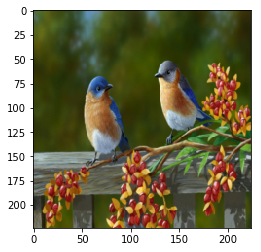

In [4]:
b=plt.imread('/data/two_birds.jpg')
b=scipy.misc.imresize(b, (224,224))
plt.imshow(b)

In [5]:
b.shape

(224, 224, 3)

In [6]:
#chichi=(b/255.0)-0.5
chichi=b-127.5
print(chichi.min(), chichi.max())

-127.5 125.5


In [7]:
shp=(1,224,224,3)
#vgg16=keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3))

In [8]:
#vgg16.summary()

In [9]:
starry=plt.imread('/data/vvg6.jpg').astype('int32')
starry.shape

(466, 640, 3)

(224, 224, 3) 5 254


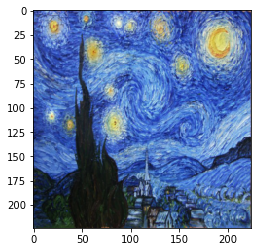

In [10]:
star=scipy.misc.imresize(starry, (224,224))
print(star.shape, star.min(), star.max())
plt.imshow(star)

In [11]:
#style_arr=(star/255.0)-0.5
style_arr=star-127.5
print(style_arr.min(), style_arr.max())

-122.5 126.5


In [12]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [13]:
def style_loss(x, targ): return K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [14]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x.shape, x.min(), x.max()

((1, 224, 224, 3), -2.4999682667512091, 2.4999956787678297)

In [15]:
shp=(1,224,224,3)
model=keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3))

In [16]:
outputs = {l.name: l.output for l in model.layers}
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
#content_name = 'block4_conv2'
content_name = 'block2_conv1'
content_layer = outputs[content_name]

In [17]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr.reshape(shp))]

In [18]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(chichi.reshape(shp)))

In [19]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [20]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += K.mean(metrics.mse(content_layer, content_targ))/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [25]:
full_evaluator = Evaluator(transfer_fn, shp)

In [26]:
iterations=15
x = rand_img(shp)

In [27]:
x = solve_image(full_evaluator, iterations, x, shp)

iteration 0 0
Current loss value: 33528.5351562
iteration 1 1
Current loss value: 6999.61181641
iteration 2 2
Current loss value: 5359.20361328
iteration 3 3
Current loss value: 4736.89746094
iteration 4 4
Current loss value: 4365.59326172
iteration 5 5
Current loss value: 4186.8515625
iteration 6 6
Current loss value: 4083.6484375
iteration 7 7
Current loss value: 4008.53955078
iteration 8 8
Current loss value: 3945.51635742
iteration 9 9
Current loss value: 3895.40771484
iteration 10 10
Current loss value: 3853.0546875
iteration 11 11
Current loss value: 3817.50927734
iteration 12 12
Current loss value: 3789.37597656
iteration 13 13
Current loss value: 3756.953125
iteration 14 14
Current loss value: 3732.74951172


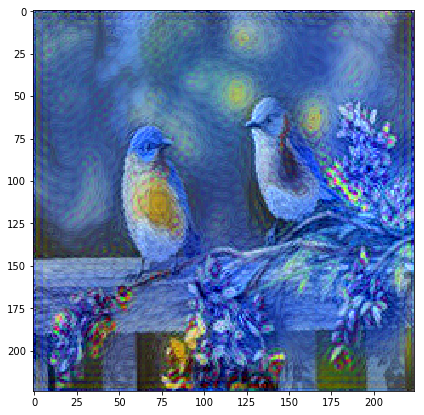

In [28]:
#This gives 1/20 weight to content loss
plt.figure(figsize=(7,7))
xf=(x+127.5)[0].astype('uint8')
plt.imshow(xf)